In [1]:
import implicit
import pandas as pd
import sqlite3

# Open database connection

In [2]:
conn = sqlite3.connect('fsdata.db')
print("Database opened successfully")

Database opened successfully


# 1. Perform data munging

Noticed in social graph there are users which are not registered in users table, and not having bi-direction relationship. Could be due to no foreign key constraint enabled on that SQLite table.

Following is to clean up these records.

## Clean socialgraph table from invalid user id, to contain only bi-direction network

In [282]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select id from users)"
sql += " or second_user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't exists in users table deleted successfully")

Record on socialgraph which doesn't exists in users table deleted successfully


In [ ]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select second_user_id from socialgraph)"
sql += " or second_user_id not in (select first_user_id from socialgraph)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't have bi-direction reference first & second user_id deleted successfully")

## Clean ratings and checkins tables from invalid user_id and invalid venue_id

In [ ]:
sql = "DELETE FROM ratings WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in users table deleted successfully")

In [ ]:
sql = "DELETE FROM ratings WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in venues table deleted successfully")

In [ ]:
sql = "DELETE FROM checkins WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in users table deleted successfully")

In [ ]:
sql = "DELETE FROM checkins WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in venues table deleted successfully")

# 2. Load Data

## Load Users

In [32]:
users = pd.read_sql_query("select * from users", conn)
users.head(5)

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144


In [33]:
users.shape

(2153469, 3)

## Load Venues

In [34]:
venues = pd.read_sql_query("select * from venues", conn)
venues.head(5)

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012


In [35]:
venues.shape

(1143090, 3)

## Load Ratings

In [36]:
ratings = pd.read_sql_query("select * from ratings", conn)
ratings.head(5)

,user_id,venue_id,rating
0,1,1,5
1,1,51,4
2,1,51,2
3,1,51,5
4,1,52,5


In [37]:
ratings.shape

(2809580, 3)

## Load Checkins

In [38]:
checkins = pd.read_sql_query("select * from checkins", conn)
checkins.head(5)

,id,user_id,venue_id,latitude,longitude,created_at
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50


In [39]:
checkins.shape

(1021966, 6)

## Load SocialGraph

In [11]:
socialgraph = pd.read_sql_query("select * from socialgraph", conn)
socialgraph.head(5)

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12


In [12]:
socialgraph.shape

(27098469, 2)

## Load user's social

In [ ]:
sql = "select u.*, s.second_user_id from users u left join socialgraph s on s.first_user_id = u.id"
users_social = pd.read_sql_query(sql, conn)
users_social

# 3. Data Exploration

## For each venues, how many users checkins?

In [40]:
sql = "select venue_id, count(*) as checkins from checkins group by venue_id order by count(*) desc"
venue_checkins = pd.read_sql_query(sql, conn)
venue_checkins

,venue_id,checkins
0,5222,25366
1,7620,23622
2,2297,23415
3,11195,19463
4,11138,18088
...,...,...
83994,87,1
83995,79,1
83996,76,1
83997,4,1


## For each venues, how many times user <span style="color:red">repeat checkins</span>?

In [41]:
sql = "select venue_id, user_id, count(*) as x_times_checkin from checkins group by venue_id, user_id having count(*) > 1 order by count(*) desc"
venue_checkins_user_repeat = pd.read_sql_query(sql, conn)
venue_checkins_user_repeat

,venue_id,user_id,x_times_checkin
0,7491,1348362,53
1,11138,660409,41
2,4432,439413,40
3,64,517520,39
4,4432,304865,39
...,...,...,...
85406,1139662,1391424,2
85407,1140238,356927,2
85408,1140905,2045336,2
85409,1142479,2056786,2


## Is there same venue rated multiple times by same user?

In [42]:
sql = "select venue_id, user_id, count(*) as x_times_rating from ratings group by venue_id, user_id having count(*)>1 order by count(*) desc"
venue_rated_user_repeat = pd.read_sql_query(sql, conn)
venue_rated_user_repeat

,venue_id,user_id,x_times_rating
0,407336,1001224,137
1,111995,107501,97
2,5732,2639,73
3,205294,67682,70
4,957067,1030348,68
...,...,...,...
298330,1142950,697097,2
298331,1142972,292419,2
298332,1142996,1016769,2
298333,1143024,401916,2


## <span style="color:blue">For each venues, what is each user's rating?</span>
(If same user give multiple rating to same venue multiple times, average it)

In [43]:
sql = "select venue_id, user_id, avg(rating) as rating from ratings group by venue_id, user_id order by avg(rating) desc"
venue_rating_by_user = pd.read_sql_query(sql, conn)
venue_rating_by_user

,venue_id,user_id,rating
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


## For each venues what is universal rating?
(Use median as venue rating from multiple users)

In [44]:
venue_rating_universal = venue_rating_by_user.groupby('venue_id')['rating'].mean().sort_values(ascending=False)
venue_rating_universal.sample(10)

venue_id
732677    5.00
232306    5.00
761779    5.00
275693    5.00
864320    4.00
972046    5.00
635397    5.00
868316    5.00
979016    4.25
614643    5.00
Name: rating, dtype: float64

## <span style="color:red">Which are the top 10 users has more checkins?</span>

In [45]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc limit 10"
users_top_10_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


# 4. Challenges for top 10 users with more checkins, build:

## 4.1 A basket of venue recommendations

Use global (universal) ranking venues as base of recommendation.

Excludes:
- Not fulfilling minimum number of reviews
- Places he ever visit before

Ranked by:
1. Highest rating
2. Highest number of people giving rating
3. Nearest house & places he has ever check in
4. Most number of checkins


#### Find out ratings

In [46]:
venue_rating = venue_rating_universal.to_frame().copy()
venue_rating

,rating
venue_id,
570409,5.000000
591469,5.000000
591482,5.000000
161606,5.000000
161615,5.000000
...,...
352717,2.003030
758013,2.002933
1132898,2.002920


#### Find out number of reviewed

In [47]:
# Need to ask how data collected, to know if same user rating same venue multiple times is an abuse?
venue_times_reviewed = ratings.copy() # If want to avoid abuse, use: "venue_rating_by_user" variable instead of ratings
venue_times_reviewed['reviewed'] = 1
venue_times_reviewed = venue_times_reviewed[['venue_id','reviewed']].groupby(['venue_id']).count()
venue_times_reviewed

,reviewed
venue_id,
1,20
2,14
3,6
4,2
5,1
...,...
1143044,1
1143045,1
1143046,1


In [48]:
venue_most_checkins = checkins.copy()
venue_most_checkins['checkins'] = 1
venue_most_checkins = venue_most_checkins[['venue_id','checkins']].groupby(['venue_id']).count()
venue_most_checkins

,checkins
venue_id,
1,4
3,1
4,1
51,13
60,17777
...,...
1142955,3
1142965,1
1142966,1


#### Decide minimal # of reviews

In [49]:
venue_times_reviewed['reviewed'].median()

1.0

In [50]:
venue_times_reviewed['reviewed'].mean()

2.46347635322939

In [51]:
min_num_of_reviews = 2

#### Finalise ranking

In [52]:
ranking = pd.concat([venue_rating, venue_times_reviewed, venue_most_checkins], axis=1)
ranking['checkins'] = ranking['checkins'].fillna(0).astype(int)
ranking.shape

(1140494, 3)

In [53]:
ranking = ranking[ranking['reviewed']>=min_num_of_reviews].sort_values(['rating','reviewed'], ascending=False)
ranking.head(20)

,rating,reviewed,checkins
venue_id,,,
101862,4.5,10,0
463173,4.5,9,0
632158,4.5,9,0
570948,4.5,8,0
683881,4.5,8,0
52200,4.5,7,0
115267,4.5,7,0
632162,4.5,7,0
290211,4.5,6,0


### Answer: For top 10 users with more checkins, a basket of venue recommendations:

In [110]:
for index, row in users_top_10_checkins.iterrows():
    user_id = row[0]
    print("------------------------------------")
    print('User ID:', user_id)
    print('Venue ID Recommentations:')
    print(ranking[~ranking.index.isin(checkins[checkins['user_id']==user_id])].head(5).round(1))

------------------------------------
User ID: 1348362
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5         8         0
------------------------------------
User ID: 1900906
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5         8         0
------------------------------------
User ID: 1326476
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5    

## 4.2 A list of likely venues the user will visit based on their friends

Use previous global (universal) ranking.

Only Include:
- Places his friends previously reviewed (give rating) or visited (checked-in)

### Answer: For top 10 users with more checkins, a list of likely venues the user will visit based on their friends

In [109]:
for index, row in users_top_10_checkins.iterrows():
    user_id = row[0]
    print("------------------------------------")
    print('User ID:', user_id)
    
    # Get his friends
    friends = socialgraph[socialgraph['first_user_id']==user_id]['second_user_id'].values
    
    if (len(friends)>0):        
        # Get venues his friends rated before
        friend_ratings = ratings[ratings['user_id'].isin(friends)]['venue_id'].unique().tolist()

        # Get venues his friend checkin before
        friend_checkins = checkins[checkins['user_id'].isin(friends)]['venue_id'].unique().tolist()

        # Combine friend_ratings and friend_checkins as friend_venues
        friend_venues = friend_ratings + list(set(friend_checkins) - set(friend_ratings))

        # Get ranking within friend_venues
        friend_recommendation = ranking[ranking.index.isin(friend_venues)]

        # Print top 5 recommendation based onf 
        print(friend_recommendation[:5].round(1))
    else:
        print('No Friend')
    

------------------------------------
User ID: 1348362
No Friend
------------------------------------
User ID: 1900906
No Friend
------------------------------------
User ID: 1326476
          rating  reviewed  checkins
venue_id                            
174555       4.2         3         0
26600        3.6         5         0
------------------------------------
User ID: 1365850
          rating  reviewed  checkins
venue_id                            
214953       4.5         2         0
642255       4.5         2         0
562          2.1      1925      1841
60           2.0     18061     17777
2297         2.0     23468     23415
------------------------------------
User ID: 386648
          rating  reviewed  checkins
venue_id                            
8622         4.5         2         0
24059        4.5         2         0
56729        4.5         2         0
57229        4.5         2         0
62033        4.5         2         0
------------------------------------
User ID:

# 4. Challenges

### For top 10 users with more checkins, build:
- Venue filtering based on user's past checkins
    - Content based filtering: Near home, near places he visited
    - Collaboration filtering: High rating
    - Collaboration filtering: the home location
- Collaboration filtering 
    - Draw path (with map) of user's checkins
    - List your friends and how close in venues visited and ranked

### Source of rankings
1. Explicit: Explicit venue ratings provided by users
2. Implicit: Number of checkins in venue

## <span style="color:red">Which are the top 10 users has more checkins?</span>

In [32]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc limit 10"
users_top_10_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


## Are top 10 users (has more checkins) ever give ratings?

In [43]:
users_top_10_checkins[users_top_10_checkins['user_id'].isin(ratings['user_id'])]

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


### Cluster ratings

In [44]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [60]:
data = venue_rating_by_user
data['rating_by_user'] = data['rating_by_user'].astype(int)
data = data[data['rating_by_user']>2]
data

,venue_id,user_id,rating_by_user
0,1,1,5
1,2,2,5
2,3,3,5
3,4,4,5
4,5,5,5
...,...,...,...
1557119,1133221,33341,3
1557120,1133221,561460,3
1557121,1135586,386648,3
1557122,1136241,318620,3


In [57]:
data = pd.get_dummies(data, columns=['rating_by_user'])
data

,venue_id,user_id,rating_by_user_2,rating_by_user_3,rating_by_user_4,rating_by_user_5
0,1,1,0,0,0,1
1,2,2,0,0,0,1
2,3,3,0,0,0,1
3,4,4,0,0,0,1
4,5,5,0,0,0,1
...,...,...,...,...,...,...
2436718,1142965,797976,1,0,0,0
2436719,1142966,1398671,1,0,0,0
2436720,1143011,83334,1,0,0,0
2436721,1143011,1626801,1,0,0,0


In [58]:
data[data['user_id']==1348362]

,venue_id,user_id,rating_by_user_2,rating_by_user_3,rating_by_user_4,rating_by_user_5
1730638,7491,1348362,1,0,0,0
2004355,39731,1348362,1,0,0,0
2201203,169552,1348362,1,0,0,0


In [ ]:
data = pd.get_dummies(ratings[['user_id','venue_id']].sample(1000), columns=['venue_id']).groupby(['user_id'], as_index=False).max()
data

### Cluster venues

In [31]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [38]:
checkins_top_10_users = checkins[checkins['user_id'].isin(users_top_10_checkins['user_id'])][['user_id','venue_id']]
checkins_top_10_users

,user_id,venue_id
1159,8622,5222
19305,8622,5222
19399,1326476,61002
22919,1326476,4432
25062,1348362,169552
...,...,...
1002612,1348362,7491
1003855,1900906,4700
1005364,651415,207183
1011134,439413,4432


In [33]:
data = pd.get_dummies(checkins[['user_id','venue_id']].sample(1000), columns=['venue_id']).groupby(['user_id'], as_index=False).max()
data

,user_id,venue_id_60,venue_id_64,venue_id_273,venue_id_389,venue_id_390,venue_id_407,venue_id_420,venue_id_432,venue_id_496,...,venue_id_1036394,venue_id_1048144,venue_id_1071979,venue_id_1076574,venue_id_1079693,venue_id_1081227,venue_id_1087225,venue_id_1099466,venue_id_1117944,venue_id_1135579
0,497,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3954,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8776,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,2144822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,2148720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,2148953,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993,2148993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data[data['user_id'] == 1348362]

,user_id,venue_id_60,venue_id_64,venue_id_273,venue_id_389,venue_id_390,venue_id_407,venue_id_420,venue_id_432,venue_id_496,...,venue_id_1036394,venue_id_1048144,venue_id_1071979,venue_id_1076574,venue_id_1079693,venue_id_1081227,venue_id_1087225,venue_id_1099466,venue_id_1117944,venue_id_1135579


In [50]:
labels = data[['user_id']]
labels

,user_id
0,4
1,20
2,153
3,205
4,258
...,...
9848,2153114
9849,2153240
9850,2153325
9851,2153404


In [51]:
features = data.drop(labels=['user_id'], axis=1)
features

,venue_id_1,venue_id_60,venue_id_64,venue_id_208,venue_id_259,venue_id_318,venue_id_382,venue_id_388,venue_id_389,venue_id_390,...,venue_id_1131767,venue_id_1131883,venue_id_1131985,venue_id_1132540,venue_id_1132898,venue_id_1135530,venue_id_1137379,venue_id_1141630,venue_id_1142843,venue_id_1143020
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9849,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
import numpy as np

kmeans_model = KMeans(n_clusters=5, max_iter=10000).fit(features)

In [53]:
print('Silhouette_score: ', metrics.silhouette_score(features, kmeans_model.labels_))

Silhouette_score:  0.05582536245926076


In [54]:
kmeans_model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [55]:
centroids = kmeans_model.cluster_centers_
centroids

array([[ 1.07550011e-04,  1.78533018e-02,  1.37664014e-02, ...,
         1.07550011e-04,  1.07550011e-04,  1.07550011e-04],
       [ 2.98155597e-19, -1.38777878e-17,  3.81639165e-17, ...,
         2.98155597e-19,  2.98155597e-19,  2.98155597e-19],
       [ 4.06575815e-20,  1.04083409e-17,  5.20417043e-18, ...,
         4.06575815e-20,  4.06575815e-20,  4.06575815e-20],
       [ 1.35525272e-19,  0.00000000e+00,  1.73472348e-17, ...,
         1.35525272e-19,  1.35525272e-19,  1.35525272e-19],
       [ 2.30392962e-19, -6.93889390e-18,  2.94902991e-17, ...,
         2.30392962e-19,  2.30392962e-19,  2.30392962e-19]])

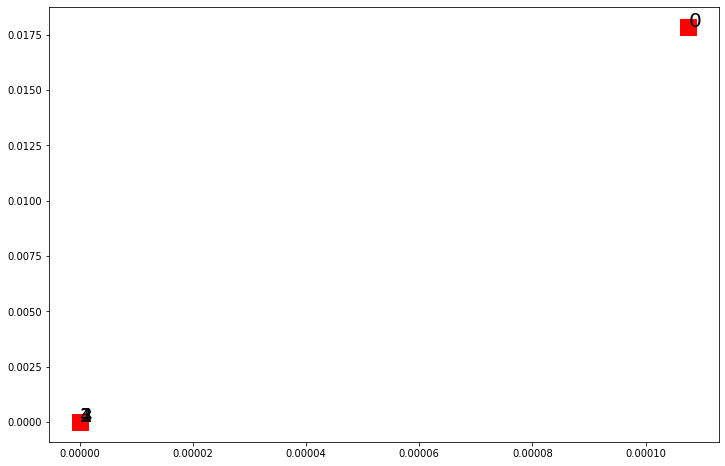

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(centroids[:,0], centroids[:,1], c='r', s=250, marker='s')

for i in range(len(centroids)):
    plt.annotate(i , (centroids[i][0], centroids[i][1]), fontsize=20)

### Get venues top 10 users visited

In [19]:
checkins_top_10 = checkins[checkins['user_id'].isin(users_top_10_checkins['user_id'])]
checkins_top_10

,id,user_id,venue_id,latitude,longitude,created_at
1159,1175,8622,5222,37.774929,-122.419415,2011-12-08 23:32:01
19305,19321,8622,5222,37.774929,-122.419415,2011-12-09 03:52:14
19399,19415,1326476,61002,33.058106,-112.047642,2011-12-09 02:26:28
22919,22935,1326476,4432,33.058106,-112.047642,2011-12-09 04:45:24
25062,25078,1348362,169552,0.000000,0.000000,2011-12-09 11:20:48
...,...,...,...,...,...,...
1002612,1002628,1348362,7491,47.606209,-122.332071,2012-04-22 14:35:22
1003855,1003871,1900906,4700,36.114646,-115.172816,2012-04-22 15:39:50
1005364,1005380,651415,207183,32.715329,-117.157255,2012-04-22 16:16:22
1011134,1011150,439413,4432,0.000000,0.000000,2012-04-22 20:01:48


In [20]:
venues[venues['id']==5222]

,id,latitude,longitude
5220,5222,37.616407,-122.386236


# 4. Collaborative filtering - Latent Factor analysis using Alternating Least Squares

User ID to look for: 1348362, but it has not done rating

In [124]:
ratings[ratings['user_id'].isin(users_top_10_checkins.values)]['user_id'].unique()

array([     45,      46,      47,      48,      52,      57,    8622,
        304865,  386648,  439413,  467043,  651415, 1326476, 1348362,
       1365850, 1900906])

In [114]:
for user in users_top_10_checkins:
    print(socialgraph[socialgraph['second_user_id']==user['user_id'].value])

TypeError: string indices must be integers

In [25]:
import implicit
import pandas as pd

In [26]:
data = venue_rating_by_user.copy()
data

,venue_id,user_id,rating_by_user
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


In [83]:
from scipy.sparse import coo_matrix

data['rating_by_user'] = data['rating_by_user'].astype(float)
data['user_id'] = data['user_id'].astype("category")
data['venue_id'] = data['venue_id'].astype("category")

rating_matrix = coo_matrix((data['rating_by_user'],
                        (data['user_id'].cat.codes.copy(),
                         data['venue_id'].cat.codes.copy())))

In [84]:
user_factors, venue_factors = implicit.alternating_least_squares(rating_matrix, factors=3, regularization=0.1)

  0%|          | 0/15 [00:00<?, ?it/s]

In [85]:
data

,venue_id,user_id,rating_by_user
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


In [86]:
data['user_id']

0                1
1                2
2                3
3                4
4                5
            ...   
2436718     797976
2436719    1398671
2436720      83334
2436721    1626801
2436722    1407243
Name: user_id, Length: 2436723, dtype: category
Categories (661986, int64): [1, 2, 3, 4, ..., 2153499, 2153500, 2153501, 2153502]

In [87]:
labels = data['user_id'].cat.codes.copy()
labels[10:20]

10        0
11        0
12        0
13        0
14        0
15        0
16        0
17      392
18    58296
19    58297
dtype: int32

In [93]:
type(labels)

pandas.core.series.Series

In [111]:
labels[labels==938359]

Series([], dtype: int32)

In [88]:
labels.loc[1348362]

49883

In [91]:
labels[1348362]

49883

In [92]:
labels.iloc[1348362]

49883

In [50]:
venue_factors.shape

(1140494, 3)

In [48]:
user_factors.shape

(661986, 3)

### Exploring user id 1326476

In [104]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc limit 10"
users_top_10_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


In [110]:
socialgraph[socialgraph['first_user_id']==1326476]

,first_user_id,second_user_id
20442874,1326476,938359


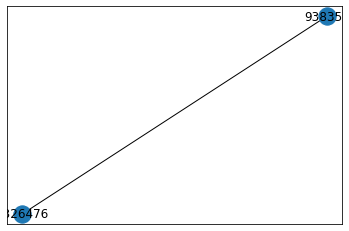

In [108]:
import networkx as nx

G_symmetric = nx.Graph()

for index, row in socialgraph[socialgraph['first_user_id']==1326476].iterrows():
    G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])

nx.spring_layout(G_symmetric)
nx.draw_networkx(G_symmetric)

In [61]:
data[data['user_id']==1348362]

,venue_id,user_id,rating_by_user
1730638,7491,1348362,2.0
2004355,39731,1348362,2.0
2201203,169552,1348362,2.0


In [63]:
data['user_id'][1730638]

1348362

In [54]:
user1348362=venue_factors.dot(user_factors[75453])

In [55]:
user1348362

array([-9.0044367e-18,  4.0332930e-18, -2.0975001e-18, ...,
        8.1639418e-19, -1.4954831e-25, -1.4954842e-25], dtype=float32)

In [56]:
user1348362=user_factors.dot(venue_factors[75453])

In [57]:
user1348362

array([ 1.4747793e-06, -1.1828600e-08,  5.1431847e-08, ...,
        1.4226359e-07,  5.8109538e-07,  1.7550565e-06], dtype=float32)

In [59]:
import heapq
heapq.nlargest(3, range(len(user1348362)), user1348362.take)

[226069, 371195, 197036]

In [134]:
data['user_id'].cat.codes

0               0
1               1
2               2
3               3
4               4
            ...  
2436718    257974
2436719    397498
2436720     56086
2436721    453968
2436722    402767
Length: 2436723, dtype: int32

In [135]:
data['user_id']

0                1
1                2
2                3
3                4
4                5
            ...   
2436718     797976
2436719    1398671
2436720      83334
2436721    1626801
2436722    1407243
Name: user_id, Length: 2436723, dtype: category
Categories (661986, int64): [1, 2, 3, 4, ..., 2153499, 2153500, 2153501, 2153502]

In [136]:
data['user_id'].cat.codes.iloc[1348362]

49883

In [137]:
data[data['user_id']==1348362]

,venue_id,user_id,rating_by_user
1730638,7491,1348362,2.0
2004355,39731,1348362,2.0
2201203,169552,1348362,2.0


In [124]:
data.iloc[1730638]

venue_id             7491
user_id           1348362
rating_by_user          2
Name: 1730638, dtype: object

In [125]:
data.iloc[2004355]

venue_id            39731
user_id           1348362
rating_by_user          2
Name: 2004355, dtype: object

In [126]:
data.iloc[2201203]

venue_id           169552
user_id           1348362
rating_by_user          2
Name: 2201203, dtype: object

In [97]:
type(rating_matrix)

scipy.sparse.coo.coo_matrix

In [142]:
type(user_factors)

numpy.ndarray

In [102]:
user_factors.shape

(1140494, 3)

In [103]:
venue_factors.shape

(661986, 3)

In [114]:
checkins[checkins['user_id'] == 1]

,id,user_id,venue_id,latitude,longitude,created_at
183631,183647,1,51,45.072464,-93.455788,2011-12-12 19:54:14
327089,327105,1,84329,45.072464,-93.455788,2011-12-25 00:47:33
609695,609711,1,7489,45.072464,-93.455788,2012-01-29 17:06:02
615229,615245,1,64,45.072464,-93.455788,2012-01-29 22:56:11
939957,939973,1,60,45.072464,-93.455788,2012-04-11 22:21:26
949915,949931,1,28192,45.072464,-93.455788,2012-04-13 01:06:20


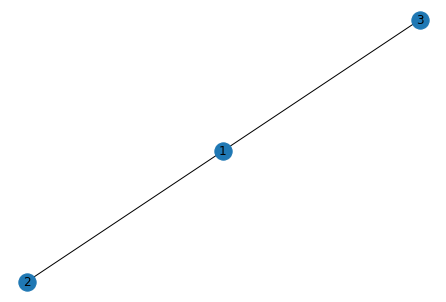

In [145]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(1,3)
nx.draw(G, with_labels=True)
plt.show()

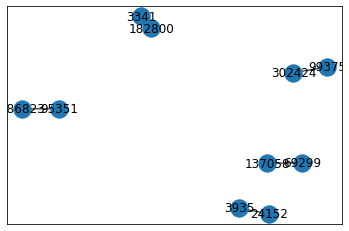

In [169]:
G_symmetric = nx.Graph()

for index, row in socialgraph.sample(5).iterrows():
    G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])

# for index, row in socialgraph.sample(100).iterrows():
#     if index < 60:
#         G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])
#     else:
#         break

nx.spring_layout(G_symmetric)
nx.draw_networkx(G_symmetric)

In [172]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

#geometry = [Point(xy) for xy in zip(users['longitude'],users['latitude'])]
geo_df = gpd.GeoDataFrame(users)

AttributeError: No geometry data set yet (expected in column 'geometry'.)

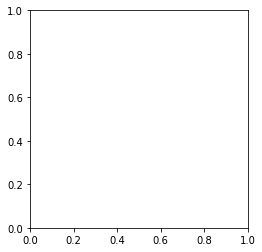

In [175]:
geo_df.plot()

In [173]:
users

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


## What are venue user like or dislike with more checkins

In [ ]:
sql = "select user_id,rating from ratings where rating=1"

# 4. Experiments

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

In [37]:
users

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [70]:
features = users.copy()
features

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [71]:
labels = features['id']
labels

0                1
1                2
2                3
3                4
4                5
            ...   
2153464    2153498
2153465    2153499
2153466    2153500
2153467    2153501
2153468    2153502
Name: id, Length: 2153469, dtype: int64

In [72]:
features.drop(labels=['id'],axis=1,inplace=True)

In [85]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
np.array(features['latitude'])

array([45.0724642, 30.6696818, 43.5499749, ...,  0.       ,  0.       ,
        0.       ])

In [88]:
lat_scaler = MinMaxScaler()
lat_scaler.fit()

ValueError: Expected 2D array, got 1D array instead:
array=[45.0724642 30.6696818 43.5499749 ...  0.         0.         0.       ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [57]:
np.array(features)

array([[ 45.0724642, -93.4557877],
       [ 30.6696818, -81.4625919],
       [ 43.5499749, -96.700327 ],
       ...,
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ]])

In [58]:
kmeans_model = KMeans(n_clusters=5, max_iter=10000).fit(features)

In [59]:
print('Silhouette_score: ', metrics.silhouette_score(features, kmeans_model.labels_))

KeyboardInterrupt: 

In [ ]:
kmeans_model.labels_

In [ ]:
centroids = kmeans_model.cluster_centers_
centroids

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(centroids[:,0], centroids[:,1], c='r', s=250, marker='s')

for i in range(len(centroids)):
    plt.annotate(i , (centroids[i][0], centroids[i][1]), fontsize=20)

In [66]:
import math
usr = users.copy()
print(usr)
#usr['x'] = math.cos(usr['latitude'].astype('float')) * math.cos(usr['longitude'].astype('float'))
#usr['y'] = math.cos(usr['latitude'].astype('float')) * math.sin(usr['longitude'].astype('float'))
#usr['y'] = math.sin(usr['latitude'].astype('float'))
#usr

              id   latitude  longitude
0              1  45.072464 -93.455788
1              2  30.669682 -81.462592
2              3  43.549975 -96.700327
3              4  44.840798 -93.298280
4              5  27.949436 -82.465144
...          ...        ...        ...
2153464  2153498   0.000000   0.000000
2153465  2153499   0.000000   0.000000
2153466  2153500   0.000000   0.000000
2153467  2153501   0.000000   0.000000
2153468  2153502   0.000000   0.000000

[2153469 rows x 3 columns]


## How many users check-in each venues?

In [147]:
sql = "select venue_id, count(*) from checkins group by venue_id order by count(*) desc"
venue_checkins = pd.read_sql_query(sql, conn)

In [148]:
venue_checkins.shape

(83999, 2)

In [150]:
venue_checkins.head(5)

,venue_id,count(*)
0,5222,25366
1,7620,23622
2,2297,23415
3,11195,19463
4,11138,18088


In [136]:
checkins['user_id']

0           539270
1          1330941
2          1330942
3           282798
4           376793
            ...   
1021961     244608
1021962    2153502
1021963     592192
1021964     494946
1021965    1368301
Name: user_id, Length: 1021966, dtype: int64

In [140]:
checkins['user_id_cat'] = checkins['user_id'].astype("category").cat.codes

In [139]:
checkins

,id,user_id,venue_id,latitude,longitude,created_at,user_id_cat
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42,90557
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19,156531
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38,156532
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06,53969
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50,69685
...,...,...,...,...,...,...,...
1021961,1021977,244608,11138,0.000000,0.000000,2012-04-23 01:47:05,48665
1021962,1021978,2153502,783,0.000000,0.000000,2012-04-23 01:42:42,485380
1021963,1021979,592192,82919,40.239812,-76.919974,2012-04-22 23:26:48,95607
1021964,1021980,494946,68691,32.912624,-96.638883,2012-04-23 00:36:33,85880


# Analysis

In [117]:
checkins['user_id']

0           539270
1          1330941
2          1330942
3           282798
4           376793
            ...   
1021961     244608
1021962    2153502
1021963     592192
1021964     494946
1021965    1368301
Name: user_id, Length: 1021966, dtype: int64

In [118]:
checkins['user_id_cat'] = checkins['user_id'].astype("category").cat.codes

In [119]:
checkins[['user_id','user_id_cat']][]

,user_id,user_id_cat
0,539270,90557
1,1330941,156531
2,1330942,156532
3,282798,53969
4,376793,69685
...,...,...
1021961,244608,48665
1021962,2153502,485380
1021963,592192,95607
1021964,494946,85880


In [103]:
from scipy.sparse import coo_matrix

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['venue_id'] = ratings['venue_id'].astype("category")
ratings_matrix = coo_matrix((ratings['rating'].astype(float),
                            (ratings['user_id'].cat.codes.copy(),
                             ratings['venue_id'].cat.codes.copy())))


In [109]:
ratings['user_id']

0                1
1                1
2                1
3                1
4                1
            ...   
2809575    2153498
2809576    2153499
2809577    2153500
2809578    2153501
2809579    2153502
Name: user_id, Length: 2809580, dtype: category
Categories (661986, int64): [1, 2, 3, 4, ..., 2153499, 2153500, 2153501, 2153502]

In [88]:
ratings['user_id'].cat

In [85]:
ratings['user_id'].cat.codes

0               0
1               0
2               0
3               0
4               0
            ...  
2809575    661981
2809576    661982
2809577    661983
2809578    661984
2809579    661985
Length: 2809580, dtype: int32

In [10]:
user_factors, venue_factors = implicit.alternating_least_squares(ratings_matrix, factors=10, regularization=0.01)

This method is deprecated. Please use the AlternatingLeastSquares class instead


  0%|          | 0/15 [00:00<?, ?it/s]

In [17]:
user_factors[30]

array([ 0.13419002,  0.00781012, -0.00983691,  0.0860741 , -0.01615641,
       -0.05233343, -0.06908152,  0.00254496,  0.04640532,  0.06905014],
      dtype=float32)

In [11]:
user = venue_factors.dot(user_factors[30])

In [19]:
ratings_matrix.shape

(661986, 1140494)

In [15]:
import heapq
heapq.nlargest(3, range(len(user)), user.take)

[5179, 24, 11150]

In [ ]:
top_venues = pd.reqd_sql_query("select venue_id")

# Close database connection

In [18]:
conn.close()
print("Database closed successfully")

Database closed successfully
